# TAP Queries
An example which shows how to make queries to the TAP service of `vo.astro.rug.nl`.

In [1]:
from astroquery.utils.tap.core import Tap

vo_url = "http://vo.astro.rug.nl/tap"

## Connect to the service

In [2]:
vo = Tap(url=vo_url, verbose=True)

Created TAP+ (v1.2.1) - Connection:
	Host: vo.astro.rug.nl
	Use HTTPS: False
	Port: 80
	SSL Port: 443


## Query the service
To query the service and immediately get the result, use the `launch_job` method and give it a query (ADQL). An example query is given below.

The result of the query is a job, from which the result can be retrieved (as an astropy Table) using the `get_results()` method.

In [54]:
query = """
SELECT TOP 10 filename, ra, dec, date_obs
FROM observations.raw
WHERE ra IS NOT NULL
"""
job = vo.launch_job(query)
table = job.get_results()
table.info()

<Table length=10>
  name    dtype  unit
-------- ------- ----
filename  object     
      ra float64  deg
     dec float64  deg
date_obs  object     


To see what is actually in the table, provided you are in a notebook, just state the table. The first row gives the column names, the second units and the third the python types. The other rows are the resulting data.

In [55]:
table

filename,ra,dec,date_obs
,deg,deg,
object,float64,float64,object
/net/vega/data/users/observatory/images/111022/STL-6303E/i/111022_Li_00000047.Jupiter.fits,34.165770833333326,12.112330555555555,2011-10-22T18:59:30.890
/net/vega/data/users/observatory/images/111022/STL-6303E/i/111022_Li_00000037.Jupiter.fits,34.165770833333326,12.112330555555555,2011-10-22T18:26:10.468
/net/vega/data/users/observatory/images/111022/STL-6303E/i/111022_Li_00000031.Jupiter.fits,33.96592499999999,11.945536111111112,2011-10-22T18:18:26.015
/net/vega/data/users/observatory/images/111022/STL-6303E/i/111022_Li_00000032.Jupiter.fits,34.165770833333326,12.112330555555555,2011-10-22T18:19:03.390
/net/vega/data/users/observatory/images/111022/STL-6303E/i/111022_Li_00000041.Jupiter.fits,34.165770833333326,12.112330555555555,2011-10-22T18:36:02.640
/net/vega/data/users/observatory/images/111022/STL-6303E/i/111022_Li_00000045.Jupiter.fits,34.165770833333326,12.112330555555555,2011-10-22T18:56:52.593
/net/vega/data/users/observatory/images/111022/STL-6303E/i/111022_Li_00000027.Jupiter.fits,34.16582916666666,12.028997222222223,2011-10-22T18:15:23.000
/net/vega/data/users/observatory/images/111022/STL-6303E/i/111022_Li_00000042.Jupiter.fits,34.165770833333326,12.112330555555555,2011-10-22T18:38:30.875


As the result is, conveniently, an astropy Table we can easily perform some operations on it. For example, get a list of coordinates using the SkyCoord class. You can explicitly give the columns to the skycoord object alongside a unit (degrees in this case), or just guess using the `guess_from_table` method.
As both give the same result, the latter is more convenient.

In [ ]:
from astropy.coordinates import SkyCoord
from astropy.table import Table

In [88]:
c = SkyCoord(table['ra'], table['dec'], unit='deg')  # explicit (give unit & columns)
c = SkyCoord.guess_from_table(table)                 # guess

c.get_constellation() # use any of the SkyCoord methods !

array(['Aries', 'Aries', 'Aries', 'Aries', 'Aries', 'Aries', 'Aries',
       'Aries', 'Aries', 'Aries'], dtype='<U19')

## Example: Get a histogram of observations per day from 2019


In [3]:
from astropy.time import Time
from matplotlib.pyplot import figure, show
import numpy as np

In [ ]:
# Get the JD version of Jan 1st of 2019
since_date = Time('2019-01-01T12:00:00.000').jd

# Prepare query (note, there is a 2000 row limit by default, use an async query above that)
query = """
SELECT obs_jd
FROM observations.raw
WHERE imagetyp = 'Light Frame' AND obs_jd >= {}
""".format(since_date)

# Launch the job and get the resulting table
job = vo.launch_job(query)
table = job.get_results()

In [209]:
days = table['obs_jd'].astype(int)  # convert to the day (e.g. noon the day before)
days -= int(since_date)  # offset by the starting date for nicer display

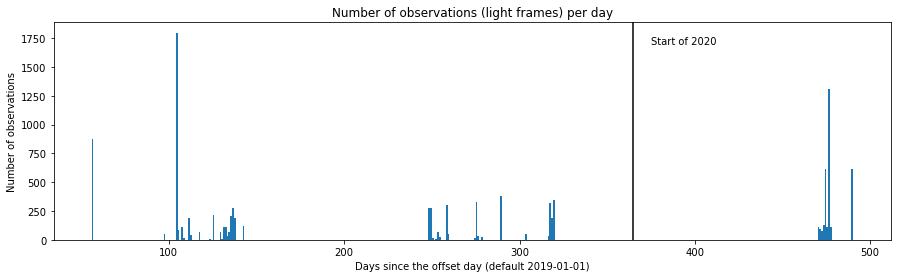

In [213]:
# Prepare the figure
fig = figure(figsize=(15, 4))
ax = fig.add_subplot(1, 1, 1)

# Plot the histogram
n, bins, patches = ax.hist(days, bins=days.max() - days.min())

# Add the 2020 line
t = Time('2020-01-01T12:00:00.000').jd - since_date
ax.axvline(t, c='k')
ax.text(t+10, ax.get_ylim()[-1] - ax.get_ylim()[-1]*.1, "Start of 2020")

# Add some labels and a title
ax.set_ylabel('Number of observations')
ax.set_xlabel('Days since the offset day (default 2019-01-01)')
ax.set_title("Number of observations (light frames) per day")
show()